# HW1 布尔查询之BSBI与索引压缩

本次作业使用斯坦福大学[CS 276 / LING 286: Information Retrieval and Web Search](https://web.stanford.edu/class/cs276/)课程的代码框架来实现。具体来说主要包含的内容有：
1. [索引构建 (40%)](#索引构建与检索-(40%)) 使用BSBI方法模拟在内存不足的情况下的索引构建方式，并应用于布尔查询
2. [索引压缩 (30%)](#索引压缩-(30%)) 使用可变长编码对构建的索引进行压缩
3. [布尔检索 (10%)](#布尔联合检索-(10%)) 对空格分隔的单词查询进行联合（与）布尔检索
3. [实验报告 (10%)](#Report-(25%)) 描述你的代码并回答一些问题
4. [额外的编码方式 (10%)](#额外的编码方式-(10%)) 鼓励使用额外的编码方式对索引进行压缩 (例如, gamma-encoding)

***为了与实验指导书的内容区分，实验报告部分均采用加粗倾斜字体***

***IDE：Pycharm 2024.3.5 (Community Edition)***

***conda version : 25.1.1***

***python version : 3.12.9.final.0***

***GitHub: https://github.com/Yifan-Guan/Information-Retrieval-Lab-1-BSBI.git***

In [ ]:
# You can add additional imports here
import sys
import pickle as pkl
import array
import os
import timeit
import contextlib

# 数据集

实验使用的文本数据是stanford.edu域下的网页内容，可从http://web.stanford.edu/class/cs276/pa/pa1-data.zip 下载。以下代码将大约170MB的文本数据下载到当前目录下，

In [ ]:
import urllib.request
import zipfile

data_url = 'http://web.stanford.edu/class/cs276/pa/pa1-data.zip'
data_dir = 'pa1-data'
urllib.request.urlretrieve(data_url, data_dir+'.zip')
zip_ref = zipfile.ZipFile(data_dir+'.zip', 'r')
zip_ref.extractall()
zip_ref.close()

***网络原因，仅测试了代码的可行性，后续直接使用了课程群提供的数据集。***

之后构建的索引会被存储到`output_dir`，`tmp`会存储测试数据（toy-data）所生成的一些临时文件

In [ ]:
try: 
    os.mkdir('output_dir')
except FileExistsError:
    pass
try: 
    os.mkdir('tmp')
except FileExistsError:
    pass
try: 
    os.mkdir('toy_output_dir')
except FileExistsError:
    pass

在数据目录下有10个子目录（命名0-9）

In [ ]:
sorted(os.listdir('pa1-data'))

每一个子目录下的文件都包含一个独立网页的内容。可以认为在同一子目录下没有同名文件，即每个文件的绝对路径不会相同。

In [ ]:
sorted(os.listdir('pa1-data/0'))[:10]

所有的网页内容已经经过处理，仅包含由空格分隔开的单词，不再需要进行额外的标准化工作。

In [ ]:
with open('pa1-data/0/3dradiology.stanford.edu_', 'r') as f:
    print(f.read())
    

***针对代码进行了一些调整***

In [ ]:
# code
pa1_data_name = "pa1-data"
pa1_data_dir_list = sorted(os.listdir("pa1-data"))
pa1_data_dir_name = pa1_data_dir_list[0]
file_list = sorted(os.listdir(pa1_data_name + '\\' + pa1_data_dir_name))
file_name = file_list[0]
print(file_name)
file_path = os.path.join(pa1_data_name, pa1_data_dir_name, file_name)
with open(file_path, 'r') as file:
    print(file.read())

***输出：***
3dradiology.stanford.edu_
3d radiology lab stanford university school of medicine stanford school of medicine 3d and quantitative imaging in the department of radiology search this site only stanford medical sites ways to give find a person alumni lane library ways to give find a person about us mission to develop and apply innovative techniques for efficient quantitative analysis and display of medical imaging data through interdisciplinary collaboration goals education to train physicians and technologists locally and worldwide in the latest developments in 3d and quantitative imaging research to develop new approaches to the exploration analysis and quantitative assesment of diagnostic images that result in a new and or more cost effective diagnostic approaches and b new techniques for the design and planning and monitoring of therapy patient care to deliver valid clinically relevant visualization and analysis of medical imaging data to the stanford community locations richard m lucas magnetic resonance imaging center 1201 welch rd p170 stanford ca 94305 5488 650 725 8432 james h clark center 318 campus drive s344 stanford ca 94305 5450 650 725 6862 directions to the 3qd lab local hotels you are here stanford medicine school of medicine departments radiology 3dq laboratory navigation for this section 3dq laboratory home education research patient care industry about us site navigation home education overview visiting fellowships reading list research overview research activities research opportunities patient care overview for physicians for patients protocol development 3dq management software case studies testimonials industry overview infrastructure and services about us faculty and staff history of the lab resources and equipment contact information jobs getting to the 3dq lab stanford medicine resources stanford medicine getting care overview find a physician find a clinical care center stanford hospital & clinics lucile packard children's hospital emergency research overview school of medicine news & resources clinical trials departments institutes & centers faculty profiles education & training overview school of medicine programs admissions continuing medical education alumni lane medical library community overview stanford health library community newsletter volunteering public service & community partnerships renewal & new building projects about us overview news careers ways to give find a person contact us maps & directions the dean's newsletter stanford university footer links contact us directions members only 2009 stanford school of medicine terms of use powered by irt


# 索引构建与检索 (40%)

作业的第一部分是使用**blocked sort-based indexing (BSBI)** 算法来构建倒排索引并实现布尔检索。关于BSBI算法可以参考老师课件或者斯坦福教材[Section 4.2](http://nlp.stanford.edu/IR-book/pdf/04const.pdf)。以下摘自教材内容

> To construct an index, we first make a pass through the collection assembling all term-docID pairs. We then sort the pairs with the term as the dominant key and docID as the secondary key. Finally, we organize the docIDs for each term into a postings list and compute statistics like term and document frequency. For small collections, all this can be done in memory. 

对于无法在内存一次性处理的较大数据集，将会使用到二级存储（如：磁盘）。

## IdMap (6%)

再次引用教材 Section 4.2:

> To make index construction more efficient, we represent terms as termIDs (instead of strings), where each termID is a unique serial number. We can build the mapping from terms to termIDs on the fly while we are processing the collection. Similarly, we also represent documents as docIDs (instead of strings).

我们首先定义一个辅助类`IdMap`，用于将字符串和数字ID进行相互映射，以满足我们在term和termID、doc和docID间转换的需求。

实现以下代码中的`_get_str` 和 `_get_id`函数，IdMap类的唯一接口是`__getitem__`，它是一个特殊函数，重写了下标运算`[]`,根据下标运算键的类型得到正确的映射值（如果不存在需要添加）。（特殊函数可参考[官方文档](https://docs.python.org/3.7/reference/datamodel.html#special-method-names)）
<br>
<br>
我们会用到字典来将字符串转换为数字，用列表来将数字转换为字符串。(4%)

In [ ]:
class IdMap:
    """Helper class to store a mapping from strings to ids."""
    def __init__(self):
        self.str_to_id = {}
        self.id_to_str = []
        
    def __len__(self):
        """Return number of terms stored in the IdMap"""
        return len(self.id_to_str)
        
    def _get_str(self, i):
        """Returns the string corresponding to a given id (`i`)."""
        ### Begin your code

        ### End your code
        
    def _get_id(self, s):
        """Returns the id corresponding to a string (`s`). 
        If `s` is not in the IdMap yet, then assigns a new id and returns the new id.
        """
        ### Begin your code

        ### End your code
            
    def __getitem__(self, key):
        """If `key` is a integer, use _get_str; 
           If `key` is a string, use _get_id;"""
        if type(key) is int:
            return self._get_str(key)
        elif type(key) is str:
            return self._get_id(key)
        else:
            raise TypeError

***get_str方法，用id检索，表中不存在则返回空字符串。get_id方法，未在字典中则加入字典，同时加入列表。***

***方法代码***

In [ ]:
    def _get_str(self, i):
        if 0 <= i < len(self.id_to_str):
            return self.id_to_str[i]
        else:
            return ""

    def _get_id(self, s):
        if s not in self.str_to_id.keys():
            self.str_to_id[s] = len(self.id_to_str)
            self.id_to_str.append(s)
        return self.str_to_id[s]

确保代码能通过以下简单测试样例 (2%)

In [ ]:
testIdMap = IdMap()
assert testIdMap['a'] == 0, "Unable to add a new string to the IdMap"
assert testIdMap['bcd'] == 1, "Unable to add a new string to the IdMap"
assert testIdMap['a'] == 0, "Unable to retrieve the id of an existing string"
assert testIdMap[1] == 'bcd', "Unable to retrive the string corresponding to a\
                                given id"
try:
    testIdMap[2]
except IndexError as e:
    assert True, "Doesn't throw an IndexError for out of range numeric ids"
assert len(testIdMap) == 2

***测试样例通过***

之后会需要你自己来写测试样例来确保你的程序正常运行

## 将倒排列表编码成字节数组 (2%)

为了高效地从磁盘读写倒排列表（文档ID），我们将其存储为字节数组的形式。代码提供了`UncompressedPostings`类来用静态函数实现对倒排列表的编码和解码。在之后的任务中你需要使用该接口实现索引压缩版本（可变长编码）。

参考:
1. https://docs.python.org/3/library/array.html
2. https://pymotw.com/3/array/#module-array

In [ ]:
class UncompressedPostings:
    
    @staticmethod
    def encode(postings_list):
        """Encodes postings_list into a stream of bytes
        
        Parameters
        ----------
        postings_list: List[int]
            List of docIDs (postings)
            
        Returns
        -------
        bytes
            bytearray representing integers in the postings_list
        """
        return array.array('L', postings_list).tobytes()
        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes postings_list from a stream of bytes
        
        Parameters
        ----------
        encoded_postings_list: bytes
            bytearray representing encoded postings list as output by encode 
            function
            
        Returns
        -------
        List[int]
            Decoded list of docIDs from encoded_postings_list
        """
        
        decoded_postings_list = array.array('L')
        decoded_postings_list.frombytes(encoded_postings_list)
        return decoded_postings_list.tolist()

运行以下代码查看其工作方式 (2%)

In [ ]:
x = UncompressedPostings.encode([1,2,3])
print(x)
print(UncompressedPostings.decode(x))

***运行结果***

b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00'

[1, 2, 3]

## 磁盘上的倒排索引 (2%)

> With main memory insufficient, we need to use an external sorting algorithm, that is, one that uses disk. For acceptable speed, the central requirement of such an algorithm is that it minimize the number of random disk seeks during sorting - sequential disk reads are far faster than seeks. 

在这一部分我们提供了一个基类`InvertedIndex`，之后会在此基础上构建它的子类`InvertedIndexWriter`, `InvertedIndexIterator` 和 `InvertedIndexMapper`。在Python中我们常用`cPickle`进行序列化，但是它并不支持部分读和部分写，无法满足BSBI算法的需要，所以我们需要定义自己的存储方式。

In [ ]:
class InvertedIndex:
    """A class that implements efficient reads and writes of an inverted index 
    to disk
    
    Attributes
    ----------
    postings_dict: Dictionary mapping: termID->(start_position_in_index_file, 
                                                number_of_postings_in_list,
                                               length_in_bytes_of_postings_list)
        This is a dictionary that maps from termIDs to a 3-tuple of metadata 
        that is helpful in reading and writing the postings in the index file 
        to/from disk. This mapping is supposed to be kept in memory. 
        start_position_in_index_file is the position (in bytes) of the postings 
        list in the index file
        number_of_postings_in_list is the number of postings (docIDs) in the 
        postings list
        length_in_bytes_of_postings_list is the length of the byte 
        encoding of the postings list
    
    terms: List[int]
        A list of termIDs to remember the order in which terms and their 
        postings lists were added to index. 
        
        After Python 3.7 we technically no longer need it because a Python dict 
        is an OrderedDict, but since it is a relatively new feature, we still
        maintain backward compatibility with a list to keep track of order of 
        insertion. 
    """
    def __init__(self, index_name, postings_encoding=None, directory=''):
        """
        Parameters
        ----------
        index_name (str): Name used to store files related to the index
        postings_encoding: A class implementing static methods for encoding and 
            decoding lists of integers. Default is None, which gets replaced
            with UncompressedPostings
        directory (str): Directory where the index files will be stored
        """

        self.index_file_path = os.path.join(directory, index_name+'.index')
        self.metadata_file_path = os.path.join(directory, index_name+'.dict')

        if postings_encoding is None:
            self.postings_encoding = UncompressedPostings
        else:
            self.postings_encoding = postings_encoding
        self.directory = directory

        self.postings_dict = {}
        self.terms = []         #Need to keep track of the order in which the 
                                #terms were inserted. Would be unnecessary 
                                #from Python 3.7 onwards

    def __enter__(self):
        """Opens the index_file and loads metadata upon entering the context"""
        # Open the index file
        self.index_file = open(self.index_file_path, 'rb+')

        # Load the postings dict and terms from the metadata file
        with open(self.metadata_file_path, 'rb') as f:
            self.postings_dict, self.terms = pkl.load(f)
            self.term_iter = self.terms.__iter__()                       

        return self
    
    def __exit__(self, exception_type, exception_value, traceback):
        """Closes the index_file and saves metadata upon exiting the context"""
        # Close the index file
        self.index_file.close()
        
        # Write the postings dict and terms to the metadata file
        with open(self.metadata_file_path, 'wb') as f:
            pkl.dump([self.postings_dict, self.terms], f)

因为是在与磁盘上的文件进行交互，所以我们提供了`__enter__`和`__exit__`函数，它使得我们能够像使用python中文件IO一样使用`with`语句。（参考[上下文管理器官方文档](https://docs.python.org/3/library/contextlib.html)）

以下是使用 `InvertedIndexWriter` 上下文管理器的实例: (2%)

```python
with InvertedIndexWriter('test', directory='tmp/') as index:
    # Some code here
```

## 索引 (30%)

> BSBI (i) segments the collection into parts of equal size, (ii) sorts the termID-docID pairs of each part in memory, (iii) stores intermediate sorted results on disk, and (iv) merges all intermediate results into the final index. 

你需要将每一个子目录当做一个块（block），并且在构建索引的过程中每次只能加载一个块（模拟内存不足）。注意到我们是将操作系统意义上的块进行了抽象。你可以认为每个块足够小，能被装载进内存。

在这一部分，我们将阶段性地构造类`BSBIIndex`。函数`index`给出了BSBI算法的框架，而你的工作则是在接下来的部分中实现函数`parse_block`, `invert_write` 和 `merge`。

In [ ]:
# Do not make any changes here, they will be overwritten while grading
class BSBIIndex:
    """ 
    Attributes
    ----------
    term_id_map(IdMap): For mapping terms to termIDs
    doc_id_map(IdMap): For mapping relative paths of documents (eg 
        0/3dradiology.stanford.edu_) to docIDs
    data_dir(str): Path to data
    output_dir(str): Path to output index files
    index_name(str): Name assigned to index
    postings_encoding: Encoding used for storing the postings.
        The default (None) implies UncompressedPostings
    """
    def __init__(self, data_dir, output_dir, index_name = "BSBI", 
                 postings_encoding = None):
        self.term_id_map = IdMap()
        self.doc_id_map = IdMap()
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.index_name = index_name
        self.postings_encoding = postings_encoding

        # Stores names of intermediate indices
        self.intermediate_indices = []
        
    def save(self):
        """Dumps doc_id_map and term_id_map into output directory"""
        
        with open(os.path.join(self.output_dir, 'terms.dict'), 'wb') as f:
            pkl.dump(self.term_id_map, f)
        with open(os.path.join(self.output_dir, 'docs.dict'), 'wb') as f:
            pkl.dump(self.doc_id_map, f)
    
    def load(self):
        """Loads doc_id_map and term_id_map from output directory"""
        
        with open(os.path.join(self.output_dir, 'terms.dict'), 'rb') as f:
            self.term_id_map = pkl.load(f)
        with open(os.path.join(self.output_dir, 'docs.dict'), 'rb') as f:
            self.doc_id_map = pkl.load(f)
            
    def index(self):
        """Base indexing code
        
        This function loops through the data directories, 
        calls parse_block to parse the documents
        calls invert_write, which inverts each block and writes to a new index
        then saves the id maps and calls merge on the intermediate indices
        """
        for block_dir_relative in sorted(next(os.walk(self.data_dir))[1]):
            td_pairs = self.parse_block(block_dir_relative)
            index_id = 'index_'+block_dir_relative
            self.intermediate_indices.append(index_id)
            with InvertedIndexWriter(index_id, directory=self.output_dir, 
                                     postings_encoding=
                                     self.postings_encoding) as index:
                self.invert_write(td_pairs, index)
                td_pairs = None
        self.save()
        with InvertedIndexWriter(self.index_name, directory=self.output_dir, 
                                 postings_encoding=
                                 self.postings_encoding) as merged_index:
            with contextlib.ExitStack() as stack:
                indices = [stack.enter_context(
                    InvertedIndexIterator(index_id, 
                                          directory=self.output_dir, 
                                          postings_encoding=
                                          self.postings_encoding)) 
                 for index_id in self.intermediate_indices]
                self.merge(indices, merged_index)

### 解析 (10%)

> The function `parse_block`  parses documents into termID-docID pairs and accumulates the pairs in memory until a block of a fixed size is full. We choose the block size to fit comfortably into memory to permit a fast in-memory sort. 

你需要将每一个子目录当做一个块，`parse_block`接收子目录路径作为参数。同一子目录下所有文件名都是不同的。 (5%)

_注意 - 我们使用 `BSBIIndex` 继承 `BSBIIndex`, 这只是对一个已存在类添加新内容的简单方法。在这里只是用来切分类的定义（jupyter notebook内教学使用，无特殊含义）。_

In [ ]:
class BSBIIndex(BSBIIndex):            
    def parse_block(self, block_dir_relative):
        """Parses a tokenized text file into termID-docID pairs
        
        Parameters
        ----------
        block_dir_relative : str
            Relative Path to the directory that contains the files for the block
        
        Returns
        -------
        List[Tuple[Int, Int]]
            Returns all the td_pairs extracted from the block
        
        Should use self.term_id_map and self.doc_id_map to get termIDs and docIDs.
        These persist across calls to parse_block
        """
        ### Begin your code

        ### End your code

***代码***

***读取文件目录下所有文件，将文件路径编码，读取文件内容，分词，对每个词编码，将文件路径编码和词编码组成列表，追加到结果列表。***

In [ ]:
    def parse_block(self, block_dir_relative):
        """
        See the statement in the document.
        :param block_dir_relative:
        """
        result = []
        block_dir_path = os.path.join(self.data_dir, block_dir_relative)
        file_list = os.listdir(str(block_dir_path))
        for file_name in file_list:
            with open(os.path.join(str(block_dir_path), file_name)) as f:
                doc_id = self.doc_id_map[os.path.join(str(block_dir_path), file_name)]
                file_word_list = f.read().split()
                for word in file_word_list:
                    term_id = self.term_id_map[word]
                    doc_term_pair = [doc_id, term_id]
                    result.append(doc_term_pair)
        return result

观察函数在测试数据上是否正常运行 (2%)

In [ ]:
with open('toy-data/0/fine.txt', 'r') as f:
    print(f.read())
with open('toy-data/0/hello.txt', 'r') as f:
    print(f.read())

In [ ]:
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'tmp/', index_name = 'toy')
BSBI_instance.parse_block('0')

写一些测试样例来确保`parse_block`方法正常运行（如：相同单词出现时是相同ID） (3%)

***测试代码***

In [ ]:
with open('toy-data/0/fine.txt', 'r') as f:
    print(f.read())
with open('toy-data/0/hello.txt', 'r') as f:
    print(f.read())

BSBI_instance = BSBIIndex(data_dir="toy-data", output_dir = 'tmp/', index_name = 'toy')
pair_list = BSBI_instance.parse_block('0')
print(pair_list)

***测试结果***

i'm fine , thank you

hi hi
how are you ?

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 5], [1, 5], [1, 6], [1, 7], [1, 4], [1, 8]]

***doc_term_pair_list中第6，7项相同，对应文件中“hi hi”，证明相同单词ID相同***

### 倒排表 (10%)

> The block is then inverted and written to disk. Inversion involves two steps. First, we sort the termID-docID pairs. Next, we collect all termID-docID pairs with the same termID into a postings list, where a posting is simply a docID. The result, an inverted index for the block we have just read, is then written to disk.

在这一部分我们添加函数`invert_write`来实现由termID-docID对构建倒排表。 

但是，我们首先需要实现类`InvertedIndexWriter`。和列表类似，该类提供了append函数，但是倒排表不会存储在内存中而是直接写入到磁盘里。 (3%)

In [ ]:
class InvertedIndexWriter(InvertedIndex):
    """"""
    def __enter__(self):
        self.index_file = open(self.index_file_path, 'wb+')              
        return self

    def append(self, term, postings_list):
        """Appends the term and postings_list to end of the index file.
        
        This function does three things, 
        1. Encodes the postings_list using self.postings_encoding
        2. Stores metadata in the form of self.terms and self.postings_dict
           Note that self.postings_dict maps termID to a 3 tuple of 
           (start_position_in_index_file, 
           number_of_postings_in_list, 
           length_in_bytes_of_postings_list)
        3. Appends the bytestream to the index file on disk

        Hint: You might find it helpful to read the Python I/O docs
        (https://docs.python.org/3/tutorial/inputoutput.html) for
        information about appending to the end of a file.
        
        Parameters
        ----------
        term:
            term or termID is the unique identifier for the term
        postings_list: List[Int]
            List of docIDs where the term appears
        """
        ### Begin your code

        ### End your code

***代码***

***先将postings_list编码，打开索引文件，文件指针移至文件尾，构建开始位置（文件尾），postings数量，postings编码长度三者的元组，元组写入文件尾。***

In [ ]:
    def append(self, term, postings_list):
        """
        See the statement in the document.
        """
        encoded_postings_list = self.postings_encoding.encode(postings_list)
        with open(self.index_file_path, 'r+b') as f:
            f.seek(0, 2)
            start_position_in_index_file = f.tell()
            number_of_postings_in_list = len(postings_list)
            length_in_bytes_of_postings_list = len(encoded_postings_list)
            self.terms.append(term)
            self.postings_dict[term] = {start_position_in_index_file,
                                        number_of_postings_in_list,
                                        length_in_bytes_of_postings_list}
            f.write(encoded_postings_list)

尽管还没有实现读取索引的类，我们还是可以用以下测试代码检测我们的实现。 (2%)

In [ ]:
with InvertedIndexWriter('test', directory='tmp/') as index:
    index.append(1, [2, 3, 4])
    index.append(2, [3, 4, 5])
    index.index_file.seek(0)
    assert index.terms == [1,2], "terms sequence incorrect"
    assert index.postings_dict == {1: (0, 3, len(UncompressedPostings.encode([2,3,4]))), 
                                   2: (len(UncompressedPostings.encode([2,3,4])), 3, 
                                       len(UncompressedPostings.encode([3,4,5])))}, "postings_dict incorrect"
    assert UncompressedPostings.decode(index.index_file.read()) == [2, 3, 4, 3, 4, 5], "postings on disk incorrect"

***测试通过***

现在我们实现 `invert_write`，它将解析得到的td_pairs转换成倒排表，并使用`InvertedIndexWriter` 类将其写入磁盘。 (3%)

In [ ]:
class BSBIIndex(BSBIIndex):
    def invert_write(self, td_pairs, index):
        """Inverts td_pairs into postings_lists and writes them to the given index
        
        Parameters
        ----------
        td_pairs: List[Tuple[Int, Int]]
            List of termID-docID pairs
        index: InvertedIndexWriter
            Inverted index on disk corresponding to the block       
        """
        ### Begin your code

        ### End your code

***代码***

***td对中的term作为字典的键，所有与term构成二元列表的doc构成的列表作为值。字典排序后追加到index。***

In [ ]:
    def invert_write(self, td_pairs, index):
        """
        See the statement in the document.
        """
        result = {}
        for [term_id, doc_id] in td_pairs:
            if term_id not in result.keys():
                result[term_id] = []
            result[term_id].append(doc_id)
        term_id_list = sorted(result.keys())
        for term_id in term_id_list:
            doc_id_list = sorted((result[term_id]))
            index.append(term_id, doc_id_list)

我们可以在测试数据上读取一个块并观察倒排索引中包含的内容。
仿照`InvertedIndexWriter`部分写一些测试样例。 (2%)

In [ ]:
### Begin your code

### End your code

***测试代码***

In [ ]:
with open('toy-data/0/fine.txt', 'r') as f:
    print(f.read())
with open('toy-data/0/hello.txt', 'r') as f:
    print(f.read())

BSBI_instance = BSBIIndex(data_dir="toy-data", output_dir = 'tmp/', index_name = 'toy')
pair_list = BSBI_instance.parse_block('0')
print(pair_list)

with InvertedIndexWriter('test', directory='temp') as index:
    BSBI_instance.invert_write(pair_list, index)
    print(index.postings_dict)

***测试结果***

i'm fine , thank you

hi hi
how are you ?

[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 1], [5, 1], [6, 1], [7, 1], [4, 1], [8, 1]]

{0: (0, 1, 4), 1: (4, 1, 4), 2: (8, 1, 4), 3: (12, 1, 4), 4: (16, 2, 8), 5: (24, 2, 8), 6: (32, 1, 4), 7: (36, 1, 4), 8: (40, 1, 4)}

### 合并 (10%)
> The algorithm simultaneously merges the ten blocks into one large merged index. To do the merging, we open all block files simultaneously, and maintain small read buffers for the ten blocks we are reading and a write buffer for the final merged index we are writing. 

Python中的迭代模型非常自然地符合我们维护一个小的读缓存的要求。我们可以迭代地从磁盘上每次读取文件的一个倒排列表。我们通过构建`InvertedIndex`的子类`InvertedIndexIterator`来完成这个迭代任务。 (3%)

In [ ]:
class InvertedIndexIterator(InvertedIndex):
    """"""
    def __enter__(self):
        """Adds an initialization_hook to the __enter__ function of super class
        """
        super().__enter__()
        self._initialization_hook()
        return self

    def _initialization_hook(self):
        """Use this function to initialize the iterator
        """
        ### Begin your code

        ### End your code

    def __iter__(self): 
        return self
    
    def __next__(self):
        """Returns the next (term, postings_list) pair in the index.
        
        Note: This function should only read a small amount of data from the 
        index file. In particular, you should not try to maintain the full 
        index file in memory.
        """
        ### Begin your code

        ### End your code

    def delete_from_disk(self):
        """Marks the index for deletion upon exit. Useful for temporary indices
        """
        self.delete_upon_exit = True

    def __exit__(self, exception_type, exception_value, traceback):
        """Delete the index file upon exiting the context along with the
        functions of the super class __exit__ function"""
        self.index_file.close()
        if hasattr(self, 'delete_upon_exit') and self.delete_upon_exit:
            os.remove(self.index_file_path)
            os.remove(self.metadata_file_path)
        else:
            with open(self.metadata_file_path, 'wb') as f:
                pkl.dump([self.postings_dict, self.terms], f)

***代码***

***初始化term位置，遍历terms中的term，从postings_dict中取出索引信息，根据索引信息在索引文件中取出encoded_postings_list并解码，
最终返回term和postings_list。***

In [ ]:
    def _initialization_hook(self):
        self.current_term_index = 0
    def __next__(self):
        if self.current_term_index < len(self.terms):
            term = self.terms[self.current_term_index]
            (start_position_in_index_file, number_of_postings_in_list,
             length_in_bytes_of_postings_list) = self.postings_dict[term]
            self.index_file.seek(start_position_in_index_file)
            encoded_postings_list = self.index_file.read(length_in_bytes_of_postings_list)
            postings_list = self.postings_encoding.decode(encoded_postings_list)
            return term, postings_list
        else:
            raise StopIteration

为了测试以上代码，我们先用`InvertedIndexWriter` 创建索引，然后再迭代遍历。写一些小的测试样例观察它是否正常运行。至少你得写一个测试，手工构建一个小的索引，用`InvertedIndexWriter`将他们写入磁盘，然后用`InvertedIndexIterator`迭代遍历倒排索引。 (2%)

***测试代码***

In [ ]:
with InvertedIndexWriter('test', directory='temp') as index:
    index.append(1, [2, 3, 4])
    index.append(2, [3, 4, 5])
    index.index_file.seek(0)
    assert index.terms == [1,2], "terms sequence incorrect"
    assert index.postings_dict == {1: (0, 3, len(UncompressedPostings.encode([2,3,4]))),
                                   2: (len(UncompressedPostings.encode([2,3,4])), 3,
                                       len(UncompressedPostings.encode([3,4,5])))}, "postings_dict incorrect"
    assert UncompressedPostings.decode(index.index_file.read()) == [2, 3, 4, 3, 4, 5], "postings on disk incorrect"

with InvertedIndexIterator('test', directory='temp') as iterator:
    for term, postings_list in iterator:
        print(term, end='')
        print(postings_list)

***测试结果***

1[2, 3, 4]

2[3, 4, 5]

> During merging, in each iteration, we select the lowest termID that has not been processed yet using a priority queue or a similar data structure. All postings lists for this termID are read and merged, and the merged list is written back to disk. Each read buffer is refilled from its file when necessary.

我们将使用`InvertedIndexIterator`来完成读取的部分，用`InvertedIndexWriter`来将合并后的索引写入磁盘。

注意到我们之前一直使用`with` 语句来打开倒排索引文件，但是现在需要程序化地完成这项工作。可以看到我们在基类`BSBIIndex`的`index`函数中使用了`contextlib`([参考文档](https://docs.python.org/3/library/contextlib.html#contextlib.ExitStack))
你的任务是合并*打开的*`InvertedIndexIterator`对象（倒排列表），并且通过一个`InvertedIndexWriter`对象每次写入一个文档列表。

既然我们知道文档列表已经排过序了，那么我们可以在线性时间内对它们进行合并排序。事实上`heapq`([参考文档](https://docs.python.org/3.0/library/heapq.html)) 是Python中一个实现了堆排序算法的标准模板。另外它还包含一个实用的函数`heapq.merge`，可以将多个已排好序的输入（可迭代）合并成一个有序的输出并返回它的迭代器。它不仅可以用来合并倒排列表，也可以合并倒排索引词典。

为了让你快速上手`heapq.merge`函数，我们提供了一个简单的使用样例。给出两个以动物和树平均寿命排序的列表，我们希望合并它们。

In [1]:
import heapq
animal_lifespans = [('Giraffe', 28), 
                   ('Rhinoceros', 40), 
                   ('Indian Elephant', 70), 
                   ('Golden Eagle', 80), 
                   ('Box turtle', 123)]

tree_lifespans = [('Gray Birch', 50), 
                  ('Black Willow', 70), 
                  ('Basswood', 100),
                  ('Bald Cypress', 600)]

lifespan_lists = [animal_lifespans, tree_lifespans]

for merged_item in heapq.merge(*lifespan_lists, key=lambda x: x[1]):
    print(merged_item)

('Giraffe', 28)
('Rhinoceros', 40)
('Gray Birch', 50)
('Indian Elephant', 70)
('Black Willow', 70)
('Golden Eagle', 80)
('Basswood', 100)
('Box turtle', 123)
('Bald Cypress', 600)


注意使用`*`将`lifespan_lists`解包作为参数，并且使用`lambda`函数来给出进行排序的key。如果你对它们不熟悉可以参考文档([unpacking lists](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists), [lambda expressions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions))。 (3%)

In [ ]:
import heapq
class BSBIIndex(BSBIIndex):
    def merge(self, indices, merged_index):
        """Merges multiple inverted indices into a single index
        
        Parameters
        ----------
        indices: List[InvertedIndexIterator]
            A list of InvertedIndexIterator objects, each representing an
            iterable inverted index for a block
        merged_index: InvertedIndexWriter
            An instance of InvertedIndexWriter object into which each merged 
            postings list is written out one at a time
        """
        ### Begin your code

        ### End your code

***代码***

***heapq合并后的term, postings_list对列表是有序的，遍历，相同term的postings_list合并，遍历到新的term时，将原本的term和postings_list
追加到writer后。***

In [ ]:
    def merge(self, indices, merge_index):
        """
        See the statement in the document.
        """
        current_term = None
        current_postings_list = None
        for term, postings_list in heapq.merge(*indices):
            if term != current_term:
                if current_term is not None:
                    merge_index.append(current_term, list(sorted(set(current_postings_list))))
                current_term = term
                current_postings_list = postings_list
            else:
                current_postings_list += postings_list
        if current_term is not None:
            merge_index.append(current_term, list(sorted((set(current_postings_list)))))

首先确保它在测试数据上正常运行

In [ ]:
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'toy_output_dir', )
BSBI_instance.index()

接下来对整个数据集构建索引 (2%)

In [ ]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.index()

***通过***

如果你在合并阶段出现了错误，可以利用以下代码来debug。

In [ ]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.intermediate_indices = ['index_'+str(i) for i in range(10)]
with InvertedIndexWriter(BSBI_instance.index_name, directory=BSBI_instance.output_dir, postings_encoding=BSBI_instance.postings_encoding) as merged_index:
    with contextlib.ExitStack() as stack:
        indices = [stack.enter_context(InvertedIndexIterator(index_id, directory=BSBI_instance.output_dir, postings_encoding=BSBI_instance.postings_encoding)) for index_id in BSBI_instance.intermediate_indices]
        BSBI_instance.merge(indices, merged_index)

## 布尔联合检索 (10%)

我们将实现BSBIIndex中的`retrieve`函数，对于给定的包含由空格分隔tokens的字符串查询，返回包含查询中所有tokens的文档列表。但是我们并不能迭代遍历整个索引或者将整个索引加载到内存来寻找相应的terms（索引太大）。

首先我们要实现`InvertedIndex`的子类`InvertedIndexMapper`，它能够找到对应terms在索引文件中位置并取出它的倒排记录表。 (2%)

In [ ]:
class InvertedIndexMapper(InvertedIndex):
    def __getitem__(self, key):
        return self._get_postings_list(key)
    
    def _get_postings_list(self, term):
        """Gets a postings list (of docIds) for `term`.
        
        This function should not iterate through the index file.
        I.e., it should only have to read the bytes from the index file
        corresponding to the postings list for the requested term.
        """

***代码***

***主体思想参见InvertedIndexIterator.\__next()__。***

In [ ]:
    def __getitem__(self, term):
        """
        Statement in document.
        """
        (start_position_in_index_file, number_of_postings_in_list,
         length_in_bytes_of_postings_list) = self.postings_dict[term]
        self.index_file.seek(start_position_in_index_file)
        encoded_postings_list = self.index_file.read(length_in_bytes_of_postings_list)
        postings_list = self.postings_encoding.decode(encoded_postings_list)
        return postings_list

写一些测试样例检测`_get_postings_list`的实现 (1%)

***测试代码***

In [ ]:
with InvertedIndexWriter('test', directory='temp') as index:
    index.append(1, [2, 3, 4])
    index.append(2, [3, 4, 5])
    index.index_file.seek(0)
    assert index.terms == [1,2], "terms sequence incorrect"
    assert index.postings_dict == {1: (0, 3, len(UncompressedPostings.encode([2,3,4]))),
                                   2: (len(UncompressedPostings.encode([2,3,4])), 3,
                                       len(UncompressedPostings.encode([3,4,5])))}, "postings_dict incorrect"
    assert UncompressedPostings.decode(index.index_file.read()) == [2, 3, 4, 3, 4, 5], "postings on disk incorrect"

with InvertedIndexIterator('test', directory='temp') as iterator:
    for term, postings_list in iterator:
        print(term, end='')
        print(postings_list)

with InvertedIndexMapper('test', directory='temp') as mapper:
    print(mapper[1])
    print(mapper[2])

***运行结果***

1[2, 3, 4]

2[3, 4, 5]

[2, 3, 4]

[3, 4, 5]

现在我们获得了查询中terms对应的倒排记录表，接着需要求他们的交集。这部分与我们之前作业的merge方法类似，请实现`sorted_intersect`函数，遍历两个有序列表并在线性时间内合并。 (2%)

In [ ]:
def sorted_intersect(list1, list2):
    """Intersects two (ascending) sorted lists and returns the sorted result
    
    Parameters
    ----------
    list1: List[Comparable]
    list2: List[Comparable]
        Sorted lists to be intersected
        
    Returns
    -------
    List[Comparable]
        Sorted intersection        
    """

***代码***

***两个指针分别遍历两表，相同则加入结果，不同则小的一方指针增加***

In [ ]:
    def sorted_intersect(list1, list2):
    """
    statement in document.
    """
    index_1 = 0
    index_2 = 0
    result = []
    while index_1 < len(list1) and index_2 < len(list2):
        if list1[index_1] == list2[index_2]:
            result.append(list1[index_1])
            index_1 += 1
            index_2 += 1
        elif list1[index_1] < list2[index_2]:
            index_1 += 1
        elif list1[index_1] > list2[index_2]:
            index_2 += 1
    return result

简单的测试样例 (1%)

***测试代码***

***结果***

[3, 5, 6]

In [ ]:
l1 = [1, 2, 3, 4, 5, 6, 7, 8]
l2 = [3, 5, 6, 10, 22]
print(sorted_intersect(l1, l2))

现在可以利用`sorted_intersect` 和 `InvertedIndexMapper`来实现`retrieve`函数。 (3%)

In [ ]:
%%tee submission/retrieve.py
class BSBIIndex(BSBIIndex):
    def retrieve(self, query):
        """Retrieves the documents corresponding to the conjunctive query
        
        Parameters
        ----------
        query: str
            Space separated list of query tokens
            
        Result
        ------
        List[str]
            Sorted list of documents which contains each of the query tokens. 
            Should be empty if no documents are found.
        
        Should NOT throw errors for terms not in corpus
        """
        if len(self.term_id_map) == 0 or len(self.doc_id_map) == 0:
            self.load()

***代码***

***将查询的字符串分词，对每个词映射ID，通过mapper查找对应的postings_list，交集返回。若存在查询中的词不在索引中，返回空列表。***

In [ ]:
    def retrieve(self, query):
        """
        statement in document.
        """

        if len(self.term_id_map) == 0 or len(self.doc_id_map) == 0:
            self.load()

        with InvertedIndexMapper(self.index_name, directory=self.output_dir,
                                 postings_encoding=self.postings_encoding) as mapper:
            result_postings_list = None
            query_term_list = query.split()
            for query_term in query_term_list:
                query_term_id = self.term_id_map.str_to_id.get(query_term)
                if query_term_id is None:
                    return []
                else:
                    postings_list = mapper[query_term]
                    if result_postings_list is None:
                        result_postings_list = postings_list
                    else:
                        result_postings_list = globalfunction.sorted_intersect(postings_list,
                                                                               result_postings_list)

            doc_list = []
            for doc_id in result_postings_list:
                doc = self.doc_id_map.id_to_str(doc_id)
                doc_list.append(doc)

            return doc_list

通过一个简单的查询来测试索引在真实数据集上是否正常工作。

In [ ]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.retrieve('boolean retrieval')

***结果***

pa1-data\1\cs276.stanford.edu_

pa1-data\1\cs276a.stanford.edu_

pa1-data\3\infolab.stanford.edu_TR_CS-TN-95-21.html

pa1-data\4\nlp.stanford.edu_IR-book_

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_references-and-further-reading-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_the-search-user-experience-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_vector-space-scoring-and-query-operator-interaction-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_weighted-zone-scoring-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_wildcard-queries-2.html

pa1-data\4\nlp.stanford.edu_IR-book_newslides.html

pa1-data\6\www-nlp.stanford.edu_IR-book_essir2011_

pa1-data\8\www.stanford.edu_class_cs124_

你也可以通过读取文件来测试其中的页面是否真的包含了查询的terms

In [ ]:
with open("pa1-data/1/cs276.stanford.edu_", 'r') as f:
    print(f.read())

测试dev queries（提前构建好的查询与结果）是否正确 (1%)

In [ ]:
for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())

***结果***

Results match for query: we are

Results match for query: stanford class

Results match for query: stanford students

Results match for query: very cool

Results match for query: the

Results match for query: a

Results match for query: the the

Results match for query: stanford computer science

如果出现了错误，可以通过以下代码比较输出与正确结果的差异

In [ ]:
set(my_results) - set(reference_results)

In [ ]:
set(reference_results) - set(my_results)

确保你构建自己的查询来测试所有可能的边界情况，例如数据集中没有出现的terms，或者拖慢合并的频繁出现的terms。

# 索引压缩  (30%)

在这部分，你将使用可变长字节编码对索引进行压缩。（gap-encoding可选，对gap进行编码）

下面几个Python运算符可能对你有帮助

In [ ]:
# Remainder (modulo) operator %

print("10 % 2 = ", 10 % 2)
print("10 % 3 = ", 10 % 3)

# Integer division in Python 3 is done by using two slash signs

print("10 / 3 = ", 10 / 3)
print("10 // 3 = ", 10 // 3)

完成下面的`CompressedPostings`类，我们将用它来替换`UncompressedPostings`。关于如何使用gap-encoding和可变长字节编码，你可以参考老师课件或者[Chapter 5](https://nlp.stanford.edu/IR-book/pdf/05comp.pdf)。 (18%)

In [ ]:
class CompressedPostings:
    #If you need any extra helper methods you can add them here 
    ### Begin your code

    ### End your code
    
    @staticmethod
    def encode(postings_list):
        """Encodes `postings_list` using gap encoding with variable byte 
        encoding for each gap
        
        Parameters
        ----------
        postings_list: List[int]
            The postings list to be encoded
        
        Returns
        -------
        bytes: 
            Bytes reprsentation of the compressed postings list 
            (as produced by `array.tobytes` function)
        """
        ### Begin your code

        ### End your code

        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes a byte representation of compressed postings list
        
        Parameters
        ----------
        encoded_postings_list: bytes
            Bytes representation as produced by `CompressedPostings.encode` 
            
        Returns
        -------
        List[int]
            Decoded postings list (each posting is a docIds)
        """
        ### Begin your code

        ### End your code

***索引压缩类：Gama编码***

***Gama编码，将二进制表示的数字去掉最高位，将与剩余部分长度相等的全1字符串与剩余部分拼接，中间用0间隔。编码时，读入postings_list的每个
数字，除第一项外，其余均表示为与前一项的差。由于Gama编码不支持数字1，所以对每一项加1后转换为对应的Gama编码。拼接所有Gama编码，前面用0补齐
使长度为8的倍数。对该字符串按8位切分转化为二进制列表，最后转化为字节。解码过程为编码的逆过程，此处不再赘述。***

In [ ]:
class CompressedPostings:
    @staticmethod
    def gama_encode(number):
        temp = bin(number)[2:]
        result = (len(temp) - 1) * '1' + '0' + temp[1:]
        return result

    @staticmethod
    def encode(postings_list):
        gap_list = [CompressedPostings.gama_encode(postings_list[0] + 1)]
        for i in range(1, len(postings_list)):
            gap_list.append(CompressedPostings.gama_encode(postings_list[i] - postings_list[i - 1] + 1))
        code_str = ''
        for g in gap_list:
            code_str += g
        code_str = ((8 - (len(code_str) % 8)) % 8) * '0' + code_str
        byte_stream = bytearray()
        for i in range(0, len(code_str), 8):
            byte_stream.append(int(code_str[i: i + 8], 2))
        return array.array('B', byte_stream).tobytes()

    @staticmethod
    def decode(encode_postings_list):
        byte_stream = array.array('B')
        byte_stream.frombytes(encode_postings_list)
        code_str = ''
        for byte in byte_stream:
            byte_str = bin(byte)[2:].zfill(8)
            code_str += byte_str
        start_index = 0
        gap_list = []
        for i in range(0, len(code_str)):
            if code_str[i] == '1':
                start_index = i
                break
        while start_index < len(code_str):
            separator_index = start_index
            while code_str[separator_index] != '0':
                separator_index += 1
            piece_len = separator_index - start_index
            end_index = separator_index + piece_len + 1
            gap_list.append(int(('1' + code_str[separator_index + 1: end_index]), 2) - 1)
            start_index = end_index
        decoded_postings_list = [gap_list[0]]
        for i in range(1, len(gap_list)):
            decoded_postings_list.append(gap_list[i] + decoded_postings_list[-1])
        return decoded_postings_list


首先，如果你实现了额外的辅助函数，写一些测试样例

In [ ]:
### Begin your code

### End your code

我们实现了一个简单的函数来测试你编码的列表是否被正确解码

In [ ]:
def test_encode_decode(l):
    e = CompressedPostings.encode(l)
    d = CompressedPostings.decode(e)
    assert d == l
    print(l, e)

写一些测试样例来确保文档列表的压缩和解压正常运行 (2%)

In [ ]:
### Begin your code

### End your code

***测试代码***

In [ ]:
def test_encode_decode(l):
    print(l)
    e = CompressedPostings.encode(l)
    print(e)
    d = CompressedPostings.decode(e)
    print(d)
    assert d == l
    print(l, e)

test_encode_decode([1, 2, 3, 4, 5, 6])
print('-' * 30)
test_encode_decode([33, 56, 535, 666])

***运行结果：成功***

[1, 2, 3, 4, 5, 6]

b'\x02I$'

[1, 2, 3, 4, 5, 6]


[1, 2, 3, 4, 5, 6] b'\x02I$'

------------------------------

[33, 56, 535, 666]

b'\x0f\x85\xe8\xffp\x7f\x04'

[33, 56, 535, 666]

[33, 56, 535, 666] b'\x0f\x85\xe8\xffp\x7f\x04'

现在让我们创建一个新的输出文件夹并使用`CompressedPostings`来构建压缩索引

In [ ]:
try: 
    os.mkdir('output_dir_compressed')
except FileExistsError:
    pass

In [ ]:
BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_compressed', postings_encoding=CompressedPostings)
BSBI_instance_compressed.index()

In [ ]:
BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_compressed', postings_encoding=CompressedPostings)
BSBI_instance_compressed.retrieve('boolean retrieval')

***运行结果***

pa1-data\1\cs276.stanford.edu_

pa1-data\1\cs276a.stanford.edu_

pa1-data\3\infolab.stanford.edu_TR_CS-TN-95-21.html

pa1-data\4\nlp.stanford.edu_IR-book_

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_references-and-further-reading-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_the-search-user-experience-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_vector-space-scoring-and-query-operator-interaction-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_weighted-zone-scoring-1.html

pa1-data\4\nlp.stanford.edu_IR-book_html_htmledition_wildcard-queries-2.html

pa1-data\4\nlp.stanford.edu_IR-book_newslides.html

pa1-data\6\www-nlp.stanford.edu_IR-book_essir2011_

pa1-data\8\www.stanford.edu_class_cs124_

像之前一样，用已构造好的查询语句来测试是否正常运行 (5%)

In [ ]:
for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance_compressed.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())

***运行结果***

Results match for query: we are

Results match for query: stanford class

Results match for query: stanford students

Results match for query: very cool

Results match for query: the

Results match for query: a

Results match for query: the the

Results match for query: stanford computer science

请追加压缩前后的文件大小截图 (5%)

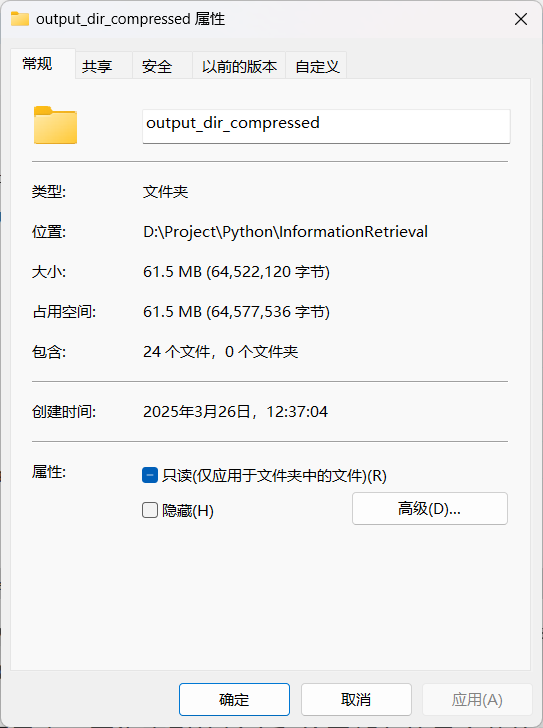

# 额外的编码方式 (10%)

通过补充`ECCompressedPostings`的`encode` 和 `decode`方法来实现一种额外的索引压缩方式。在我们课上学的就是**gamma-encoding** 。另外如果大家感兴趣的话也可以了解**Delta Encoding** ，[ALGORITHM SIMPLE-9](https://github.com/manning/CompressionAlgorithms#simple-9) 等。

你应该以多字节（而不是bits）来存储倒排记录表，因为索引的长度和位置都存的是字节信息。 (4%)

In [ ]:
class ECCompressedPostings:
    #If you need any extra helper methods you can add them here 
    ### Begin your code

    ### End your code
    
    @staticmethod
    def encode(postings_list):
        """Encodes `postings_list` 
        
        Parameters
        ----------
        postings_list: List[int]
            The postings list to be encoded
        
        Returns
        -------
        bytes: 
            Bytes reprsentation of the compressed postings list 
        """
        ### Begin your code

        ### End your code

        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes a byte representation of compressed postings list
        
        Parameters
        ----------
        encoded_postings_list: bytes
            Bytes representation as produced by `CompressedPostings.encode` 
            
        Returns
        -------
        List[int]
            Decoded postings list (each posting is a docId)
        """
        ### Begin your code

        ### End your code

***索引压缩类：Variable Byte编码***

***仅介绍VB编码的实现方式，具体编解码过程请参见上文Gama编码。对一个二进制数，前补位使其长度为7的倍数，后按7位一组，第一组前加1，之后的
每一组前加0，将所有组拼接得到结果。***

In [ ]:
import array

class ECCompressedPostings:
    @staticmethod
    def vb_code(postings):
        bin_postings = bin(postings)[2: ]
        result = ''
        start_index = 0
        add_number = (7 - len(bin_postings) % 7) % 7
        bin_postings = add_number * '0' + bin_postings
        sign = '1'
        while start_index < len(bin_postings):
            end_index = start_index + 7
            temp_piece = bin_postings[start_index: end_index]
            result = result + sign + temp_piece
            sign = '0'
            start_index = end_index
        return result


    @staticmethod
    def encode(postings_list):
        gap_list = [ECCompressedPostings.vb_code(postings_list[0])]
        for i in range(1, len(postings_list)):
            gap_list.append(ECCompressedPostings.vb_code(postings_list[i] - postings_list[i - 1]))
        code_str = ''
        for g in gap_list:
            code_str += g
        code_str = ((8 - (len(code_str) % 8)) % 8) * '0' + code_str
        byte_stream = bytearray()
        for i in range(0, len(code_str), 8):
            byte_stream.append(int(code_str[i: i + 8], 2))
        return array.array('B', byte_stream).tobytes()

    @staticmethod
    def decode(encoded_postings_list):
        byte_stream = array.array('B')
        byte_stream.frombytes(encoded_postings_list)
        code_str = ''
        for byte in byte_stream:
            byte_str = bin(byte)[2:].zfill(8)
            code_str += byte_str
        start_index = 0
        gap_list = []
        for i in range(0, len(code_str)):
            if code_str[i] == '1':
                start_index = i
                break
        temp_piece = ''
        while start_index < len(code_str):
            end_index = start_index + 8
            temp_piece += code_str[start_index + 1: end_index]
            if end_index == len(code_str) or code_str[end_index] == '1':
                gap_list.append(int(temp_piece, 2))
                temp_piece = ''
            start_index = end_index

        decoded_postings_list = [gap_list[0]]
        for i in range(1, len(gap_list)):
            decoded_postings_list.append(gap_list[i] + decoded_postings_list[-1])
        return decoded_postings_list

同上，写一些测试样例来确保代码正常运行 (3%)

***测试代码***

In [ ]:
def test_encode_decode(l):
    print(l)
    e = ECCompressedPostings.encode(l)
    print(e)
    d = ECCompressedPostings.decode(e)
    print(d)
    assert d == l
    print(l, e)

test_encode_decode([1, 2, 3, 4, 5, 6])
print('-' * 30)
test_encode_decode([33, 56, 535, 666])

***结果***

[1, 2, 3, 4, 5, 6]

b'\x81\x81\x81\x81\x81\x81'

[1, 2, 3, 4, 5, 6]

[1, 2, 3, 4, 5, 6] b'\x81\x81\x81\x81\x81\x81'

------------------------------

[33, 56, 535, 666]

b'\xa1\x97\x83_\x81\x03'

[33, 56, 535, 666]

[33, 56, 535, 666] b'\xa1\x97\x83_\x81\x03'

请追加压缩前后的文件大小截图 (3%)

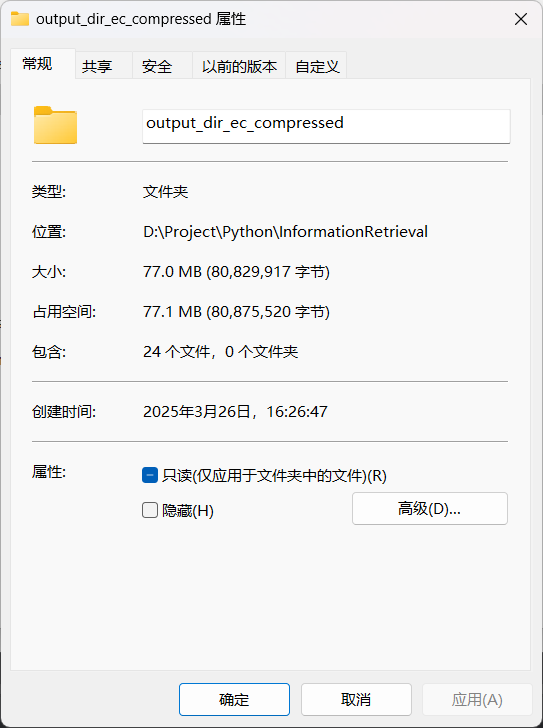

# 作业提交

本次作业用时约3周，截止日期为2024.03.26。请大家在截止日期前将代码、实验报告（可单独撰写，也可整合在jupyter notebook中）一起提交到ir24fall@163.com，邮件和文件命名方式均为`学号_姓名_hw1`，如`1811412_戚晓睿_hw1.ipynb`